# Task 2 - 🕸 Network Analysis of Prague Integrated Transport (PIT)

## 📚 Data
**Data source**: Our dataset will be sourced from the [open data of Prague Integrated Transport](https://pid.cz/o-systemu/opendata/). Specifically, we will be working with the [timetable data](https://pid.cz/o-systemu/opendata/#h-gtfs), which is originally in the GTFS (General Transit Feed Specification) format. You can find more information about all the files and their attributes in the [GTFS format documentation](https://developers.google.com/transit/gtfs/reference).


## Assignment
> ☝️ Use markdown cells! Explain all important steps, describe visualizations, and note any observations.

**✨ Dataset**
* Load data from the file `d.csv`, which is the dataset, containing records for each **two consecutive stops** of a vehicle.
* The structure is as follows (for simplicity, we are not considering service `start_date` and `end_date`):
| stop_from | stop_from_name | stop_to | stop_to_name | depart_from | arrive_to | route_type | is_night | mon | tue | wed | thu | fri | sat | sun |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| U699Z3P | Stadion Strahov | U981Z1P | Koleje Strahov | 7:24:00 | 7:25:00 | 3 | 0 | 1 | 1 | 1 | 1 | 1 | 0 | 0 |

* The unique identifier for a stop is the **stop name**. Be cautious of the same stop names for different modes of transport - consider them as the same station in such cases.

**⚙️ Data Preprocessing**

* You will likely want to preprocess the `depart_from` and `arrive_to` attributes. They contain time information longer than 24 hours (approximately 1.5% of records). From the GTFS format reference (information about the column from which `depart_from` and `arrive_to` are derived): _Arrival time at a specific stop for a specific trip on a route. … For times occurring after midnight on the service day, enter the time as a value greater than 24:00:00 in HH:MM:SS local time for the day on which the trip schedule begins._ However, you may also encounter incorrect times that start with a value greater than 24. You can handle all these cases by using the **modulo 24** operation ☝️.

**🕸️ Basic Network Analysis**

The task is to analyze the PIT (Prague Integrated Transport) stop network. Stops will be nodes in the network. There is a directed edge between two stops if they are two consecutive stops of a vehicle (there is at least one record in the dataset with corresponding `stop_from` and `stop_to`). The weight of an edge is equal to the number of vehicles that pass through that route during one week.

Here are the steps to follow:

1. Start by choosing any package for network analysis and visualization.
2. Create a data representation from the dataset suitable for your chosen visualization package.
3. Visualize the network - the visualization must be clear, and you can choose to visualize a subset of the network for clarity.
4. Analyze the importance of stops over one week (Monday - Sunday) using at least three centrality measures and provide a verbal explanation of what these measures mean in the context of the specific data.
5. Create a visualization for at least one centrality measure.

**❓ Custom Questions**

Create three questions based on dataset filtering and answer them with suitable visualizations. Questions for inspiration:

* Do important stops change depending on day/night operations?
* Is there a difference in stop traffic during weekdays and weekends?
* ...

**🔥 Extra Data**

In the `stops.txt` file, the **latitude and longitude** of each stop are provided. You can use this data to enhance your analysis and it may assist in graph layout. ☝️ Be aware of stops with slightly different locations but the same name for different modes of transport. You need to propose a solution and justify it.

## LET'S START

In [1]:
# a teď už je to na vás 💪
# níže vložte své řešení
import pandas as pd
import numpy as np
import networkx as nx
import math

import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

## Data analysing

In [2]:
pid = pd . read_csv ( "d.csv" )

A short analysis of dataset `d.csv`.

In [3]:
display ( pid . shape )
display ( pid . info ( ) )
display ( pid . nunique ( ) )
display ( pid . head ( 5 ) )

(1642433, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642433 entries, 0 to 1642432
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   stop_from       1642433 non-null  object
 1   stop_from_name  1642433 non-null  object
 2   stop_to         1642433 non-null  object
 3   stop_to_name    1642433 non-null  object
 4   depart_from     1642433 non-null  object
 5   arrive_to       1642433 non-null  object
 6   route_type      1642433 non-null  int64 
 7   is_night        1642433 non-null  int64 
 8   monday          1642433 non-null  int64 
 9   tuesday         1642433 non-null  int64 
 10  wednesday       1642433 non-null  int64 
 11  thursday        1642433 non-null  int64 
 12  friday          1642433 non-null  int64 
 13  saturday        1642433 non-null  int64 
 14  sunday          1642433 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 188.0+ MB


None

stop_from         15178
stop_from_name     7389
stop_to           15154
stop_to_name       7387
depart_from       14021
arrive_to         13858
route_type            6
is_night              2
monday                2
tuesday               2
wednesday             2
thursday              2
friday                2
saturday              2
sunday                2
dtype: int64

,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,U2991Z301,Hněvice,T58005,Hněvice seř.n.,4:53:00,4:54:30,2,0,1,1,1,1,1,0,0
1,T58005,Hněvice seř.n.,U4610Z301,Záluží,4:54:30,4:56:00,2,0,1,1,1,1,1,0,0
2,U4610Z301,Záluží,U4609Z301,Dobříň,4:56:00,4:59:00,2,0,1,1,1,1,1,0,0
3,U4609Z301,Dobříň,U4608Z301,Roudnice nad Labem,4:59:00,5:03:00,2,0,1,1,1,1,1,0,0
4,U4608Z301,Roudnice nad Labem,U4609Z301,Dobříň,4:36:00,4:38:00,2,0,1,1,1,1,1,0,0


Our dataset has `15 features`. 

Columns **stop_from**-**arrive_to** show general information about the stops, departure and arrival time. All columns from **is_night** to **sunday** have two values each ( `0 - False`, `1 - True` ). 
From the dataset's documentation we get the following information about the values of the **route_type** column:

* 0 - Tram, Streetcar, Light rail. Any light rail or street level system within a metropolitan area.
* 1 - Subway, Metro. Any underground rail system within a metropolitan area.
* 2 - Rail. Used for intercity or long-distance travel.
* 3 - Bus. Used for short- and long-distance bus routes.
* 4 - Ferry. Used for short- and long-distance boat service.
* 5 - Cable tram. Used for street-level rail cars where the cable runs beneath the vehicle, e.g., cable car in San Francisco.
* 6 - Aerial lift, suspended cable car (e.g., gondola lift, aerial tramway). Cable transport where cabins, cars, gondolas or open chairs are suspended by means of one or more cables.
* 7 - Funicular. Any rail system designed for steep inclines.
* 11 - Trolleybus. Electric buses that draw power from overhead wires using poles.
* 12 - Monorail. Railway in which the track consists of a single rail or a beam.

In [4]:
pid [ "route_type" ] . unique ( )

array([2, 3, 0, 4, 7, 1], dtype=int64)

Exploring the **stop_from** and **stop_to** columns. 

In [5]:
from_strahov = pid [ pid [ "stop_from_name" ] == "Koleje Strahov" ]
display ( from_strahov . head ( 5 ) )
display ( from_strahov [ "stop_from" ] . unique () )
display ( from_strahov [ "stop_to" ] . unique () )
display ( from_strahov [ "stop_to_name" ] . unique () )
to_strahov = pid [ pid [ "stop_to_name" ] == "Koleje Strahov" ]
display ( to_strahov . head ( 5 ) )
display ( to_strahov [ "stop_from" ] . unique () )
display ( to_strahov [ "stop_from_name" ] . unique () )
display ( to_strahov [ "stop_to" ] . unique () )

,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday
328012,U981Z1P,Koleje Strahov,U362Z9P,Malovanka,12:01:00,12:03:00,3,0,1,1,1,1,1,0,0
328024,U981Z2P,Koleje Strahov,U699Z12P,Stadion Strahov,12:33:00,12:34:00,3,0,1,1,1,1,1,0,0
328026,U981Z1P,Koleje Strahov,U362Z9P,Malovanka,12:41:00,12:43:00,3,0,1,1,1,1,1,0,0
328038,U981Z2P,Koleje Strahov,U699Z12P,Stadion Strahov,13:23:00,13:24:00,3,0,1,1,1,1,1,0,0
328040,U981Z1P,Koleje Strahov,U362Z9P,Malovanka,13:31:00,13:33:00,3,0,1,1,1,1,1,0,0


array(['U981Z1P', 'U981Z2P'], dtype=object)

array(['U362Z9P', 'U699Z12P', 'U699Z4P', 'U362Z12P'], dtype=object)

array(['Malovanka', 'Stadion Strahov'], dtype=object)

,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday
328011,U699Z3P,Stadion Strahov,U981Z1P,Koleje Strahov,12:00:00,12:01:00,3,0,1,1,1,1,1,0,0
328023,U362Z10P,Malovanka,U981Z2P,Koleje Strahov,12:31:00,12:33:00,3,0,1,1,1,1,1,0,0
328025,U699Z3P,Stadion Strahov,U981Z1P,Koleje Strahov,12:40:00,12:41:00,3,0,1,1,1,1,1,0,0
328037,U362Z10P,Malovanka,U981Z2P,Koleje Strahov,13:21:00,13:23:00,3,0,1,1,1,1,1,0,0
328039,U699Z3P,Stadion Strahov,U981Z1P,Koleje Strahov,13:30:00,13:31:00,3,0,1,1,1,1,1,0,0


array(['U699Z3P', 'U362Z10P'], dtype=object)

array(['Stadion Strahov', 'Malovanka'], dtype=object)

array(['U981Z1P', 'U981Z2P'], dtype=object)

From personal experience with `Koleje Strahov`, I have found that the values of these columns are the indexes of each physical transport stop. 

A short analysis of dataset `stops.txt`.

In [6]:
stops = pd . read_csv ( "stops.txt" )

In [7]:
display ( stops . shape )
display ( stops . info ( ) )
display ( stops . nunique ( ) )
display ( stops . head ( 5 ) )

(16435, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16435 entries, 0 to 16434
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   stop_id              16435 non-null  object 
 1   stop_name            15936 non-null  object 
 2   stop_lat             16435 non-null  float64
 3   stop_lon             16435 non-null  float64
 4   zone_id              15408 non-null  object 
 5   stop_url             0 non-null      float64
 6   location_type        16435 non-null  int64  
 7   parent_station       954 non-null    object 
 8   wheelchair_boarding  16435 non-null  int64  
 9   level_id             954 non-null    object 
 10  platform_code        14750 non-null  object 
 11  asw_node_id          15748 non-null  float64
 12  asw_stop_id          15354 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 1.6+ MB


None

stop_id                16435
stop_name               7547
stop_lat               14833
stop_lon               15387
zone_id                   27
stop_url                   0
location_type              4
parent_station            58
wheelchair_boarding        3
level_id                 171
platform_code             81
asw_node_id             6986
asw_stop_id               63
dtype: int64

,stop_id,stop_name,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,wheelchair_boarding,level_id,platform_code,asw_node_id,asw_stop_id
0,U50S1,Budějovická,50.044411,14.448787,P,NaN,1,NaN,1,NaN,NaN,50.0,NaN
1,U52S1,Chodov,50.031672,14.490961,P,NaN,1,NaN,1,NaN,NaN,52.0,NaN
2,U75S1,Kolbenova,50.110395,14.516398,P,NaN,1,NaN,1,NaN,NaN,75.0,NaN
3,U78S1,Ládví,50.126591,14.469451,P,NaN,1,NaN,1,NaN,NaN,78.0,NaN
4,U100S1,Vltavská,50.100298,14.438492,P,NaN,1,NaN,1,NaN,NaN,100.0,NaN


In [8]:
stops [ stops [ "stop_name" ] == "Koleje Strahov" ]

,stop_id,stop_name,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,wheelchair_boarding,level_id,platform_code,asw_node_id,asw_stop_id
3182,U981Z1P,Koleje Strahov,50.080502,14.390192,P,NaN,0,NaN,0,NaN,A,981.0,1.0
3183,U981Z2P,Koleje Strahov,50.080185,14.389872,P,NaN,0,NaN,0,NaN,B,981.0,2.0


## Adding the coordinates of transport stops

Add all the names of transport stops into one `set`.

In [9]:
pid_stops_name = set( pid [ "stop_from_name" ] )
pid_stops_name . update ( pid [ "stop_to_name" ] )
display ( len ( pid_stops_name ) )

7396

Create a separate data structure to store information about the `physical coordinates` of each transport stop.

However, as we have seen during our analysis of the `Koleje Strahov` stop, a transport stop can be located in two or more locations and there are different coordinates for all of them. We only need to have one coordinate value (something average).

The best solution to our problem would be to find the `geometric median`: In geometry, the geometric median of a discrete set of sample points in a Euclidean space is the point minimizing the sum of distances to the sample points ( src: [Geometric median](https://en.wikipedia.org/wiki/Geometric_median#:~:text=In%20geometry%2C%20the%20geometric%20median,distances%20to%20the%20sample%20points.) ). 

However implementing a geometric median is not an easy task ( src: [Geometric median implementation](https://www.geeksforgeeks.org/geometric-median/) ). So I decided to look for the point where the sum will be the minimum of the sum of all `Manhattan distances` rather than the sum of all `Euclidean` ( src: [Find a point such that sum of the Manhattan distances is minimized](https://www.geeksforgeeks.org/find-a-point-such-that-sum-of-the-manhattan-distances-is-minimized/) ).

In [10]:
stop_location = {}
for name in pid_stops_name:
    coordinates = np . append ( [ stops [ stops [ "stop_name" ] == name ][ "stop_lon" ]], [ stops [ stops [ "stop_name" ] == name ][ "stop_lat" ]], axis = 0 )
    for coordinate in coordinates:
        coordinate . sort ( )
    stop_location [ name ] = np . array ( [ coordinates [ 0 ][ ( len ( coordinates [ 0 ] ) + 1 ) // 2  - 1 ], coordinates [ 1 ][ ( len ( coordinates [ 1 ] ) + 1 ) // 2  - 1 ] ] )

In [11]:
display ( len ( stop_location ) )
display ( stops [ stops [ "stop_name" ] == "Koleje Strahov" ][[ "stop_lon", "stop_lat" ]] )
display ( stop_location [ "Koleje Strahov"] )

7396

,stop_lon,stop_lat
3182,14.390192,50.080502
3183,14.389872,50.080185


array([14.389872, 50.080185])

## Editing the Depart_from and Arrive_By columns

In [12]:
display ( pid [ pid [ "depart_from" ] . apply ( lambda x: int ( x . split ( ':' )[0]) >= 24 ) ] . head ( 7 ) )
display ( pid [ pid [ "arrive_to" ] . apply ( lambda x: int ( x . split ( ':' )[0]) >= 24 ) ] . head ( 7 ) )

,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday
2021,U9343Z301,Louny střed,U9344Z301,Louny město,24:01:30,24:03:00,2,0,1,1,1,1,0,1,1
2023,U9343Z301,Louny střed,U9344Z301,Louny město,24:01:30,24:03:00,2,0,0,0,0,0,1,0,0
8499,U648Z4P,Sídliště Bohnice,U912Z4P,Zhořelecká,24:08:00,24:09:00,3,0,1,1,1,1,1,1,1
8500,U912Z4P,Zhořelecká,U371Z1P,Krakov,24:09:00,24:10:00,3,0,1,1,1,1,1,1,1
8501,U371Z1P,Krakov,U924Z1P,Na Pazderce,24:10:00,24:11:00,3,0,1,1,1,1,1,1,1
8502,U924Z1P,Na Pazderce,U925Z2P,Dunajecká,24:11:00,24:12:00,3,0,1,1,1,1,1,1,1
8503,U925Z2P,Dunajecká,U544Z2P,Čimický háj,24:12:00,24:13:00,3,0,1,1,1,1,1,1,1


,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday
2020,U4877Z301,Louny,U9343Z301,Louny střed,23:59:00,24:01:30,2,0,1,1,1,1,0,1,1
2021,U9343Z301,Louny střed,U9344Z301,Louny město,24:01:30,24:03:00,2,0,1,1,1,1,0,1,1
2022,U4877Z301,Louny,U9343Z301,Louny střed,23:59:00,24:01:30,2,0,0,0,0,0,1,0,0
2023,U9343Z301,Louny střed,U9344Z301,Louny město,24:01:30,24:03:00,2,0,0,0,0,0,1,0,0
8499,U648Z4P,Sídliště Bohnice,U912Z4P,Zhořelecká,24:08:00,24:09:00,3,0,1,1,1,1,1,1,1
8500,U912Z4P,Zhořelecká,U371Z1P,Krakov,24:09:00,24:10:00,3,0,1,1,1,1,1,1,1
8501,U371Z1P,Krakov,U924Z1P,Na Pazderce,24:10:00,24:11:00,3,0,1,1,1,1,1,1,1


Create a function that uses a `modulo 24` for the hours.

In [13]:
def correct_time ( time ):
    hours = int ( time . split ( ':' )[0] )
    if hours >= 24:
        hours %= 24
        time = str ( hours ) + ':' + time . split ( ':' )[1] + ':' + time . split ( ':' )[2]
    return time

In [14]:
pid [ "depart_from" ] = pid [ "depart_from" ] . apply ( correct_time )
pid [ "arrive_to" ] = pid [ "arrive_to" ] . apply ( correct_time )

Checking if the function is working `correctly`.

In [15]:
display ( pid [ pid [ "depart_from" ] . apply ( lambda x: int ( x . split ( ':' )[0]) >= 24 ) ] . head ( 7 ) )
display ( pid [ pid [ "arrive_to" ] . apply ( lambda x: int ( x . split ( ':' )[0]) >= 24 ) ] . head ( 7 ) )
display ( pid . loc [[ 2020, 2021, 2022 ]] )

,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday


,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday


,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday
2020,U4877Z301,Louny,U9343Z301,Louny střed,23:59:00,0:01:30,2,0,1,1,1,1,0,1,1
2021,U9343Z301,Louny střed,U9344Z301,Louny město,0:01:30,0:03:00,2,0,1,1,1,1,0,1,1
2022,U4877Z301,Louny,U9343Z301,Louny střed,23:59:00,0:01:30,2,0,0,0,0,0,1,0,0


## Adding edge weights

Use the groupby function to create all the edges ( `from where`, `to where` and `route type` ) and use the count function for every day of the week to `count the number of routes` that pass through that edge during this day.

In [16]:
data_for_graph = pid[ pid["monday"] == 1 ][ ["stop_from_name", "stop_to_name", "route_type", "monday"] ] . groupby ( ["stop_from_name", "stop_to_name", "route_type"] ) . count ( )
for column in pid . loc [:,"tuesday":"sunday"]:
    data_for_graph = pd . concat ( [ data_for_graph, pid [ pid[column] == 1 ][["stop_from_name", "stop_to_name", "route_type", column]] . groupby ( ["stop_from_name", "stop_to_name", "route_type"]) . count ( )], axis = 1 )
data_for_graph . replace ( np . nan, 0, inplace = True )

Counting the number of routes in `total` for the week.

In [17]:
data_for_graph [ "total" ] = data_for_graph . sum ( axis = 1 )
data_for_graph

monday  tuesday  \
stop_from_name     stop_to_name                   route_type                    
AHr Km 11,485      Mstětice                       2             50.0     50.0   
                   vl.v km 9,980                  2             48.0     48.0   
Albertov           Botanická zahrada              0            550.0    550.0   
                   Ostrčilovo náměstí             0            912.0    912.0   
                   Výtoň                          0            302.0    302.0   
...                                                              ...      ...   
Svijany,na nájezdu Hodkovice n.Mohelkou,aut.nádr. 3              0.0      0.0   
Těšnov             Florenc                        0              0.0      0.0   
Velká Chyška       Pacov,Hrádek SOMPO             3              0.0      0.0   
Zvonařka           Bruselská                      0              0.0      0.0   
Čechtice           Křivsoudov                     3              0.0      0.0   

                                                              wednesday  \
stop_from_name     stop_to_name                   route_type              
AHr Km 11,485      Mstětice                       2                50.0   
                   vl.v km 9,980                  2                48.0   
Albertov           Botanická zahrada              0               550.0   
                   Ostrčilovo náměstí             0               912.0   
                   Výtoň                          0               302.0   
...                                                                 ...   
Svijany,na nájezdu Hodkovice n.Mohelkou,aut.nádr. 3                 0.0   
Těšnov             Florenc                        0                 0.0   
Velká Chyška       Pacov,Hrádek SOMPO             3                 0.0   
Zvonařka           Bruselská                      0                 0.0   
Čechtice           Křivsoudov                     3                 0.0   

                                                              thursday  \
stop_from_name     stop_to_name                   route_type             
AHr Km 11,485      Mstětice                       2               50.0   
                   vl.v km 9,980                  2               48.0   
Albertov           Botanická zahrada              0              550.0   
                   Ostrčilovo náměstí             0              912.0   
                   Výtoň                          0              302.0   
...                                                                ...   
Svijany,na nájezdu Hodkovice n.Mohelkou,aut.nádr. 3                0.0   
Těšnov             Florenc                        0                0.0   
Velká Chyška       Pacov,Hrádek SOMPO             3                0.0   
Zvonařka           Bruselská                      0                0.0   
Čechtice           Křivsoudov                     3                0.0   

                                                              friday  \
stop_from_name     stop_to_name                   route_type           
AHr Km 11,485      Mstětice                       2             51.0   
                   vl.v km 9,980                  2             48.0   
Albertov           Botanická zahrada              0            550.0   
                   Ostrčilovo náměstí             0            912.0   
                   Výtoň                          0            302.0   
...                                                              ...   
Svijany,na nájezdu Hodkovice n.Mohelkou,aut.nádr. 3              0.0   
Těšnov             Florenc                        0              0.0   
Velká Chyška       Pacov,Hrádek SOMPO             3              0.0   
Zvonařka           Bruselská                      0              0.0   
Čechtice           Křivsoudov                     3              0.0   

                                                              saturday  \
stop_from_name     stop_to_name                   route_ty

## Graph creating and drawing

Because several edges can lead from one graph node to another (depending on the **route_type**) we will work with the class `MultiDiGraph`. 

In [18]:
pid_graph = nx . MultiDiGraph ( )

Adding *graph nodes* and their *attributes* ( `location` ). 

In [19]:
for key, value in stop_location . items ( ):
    pid_graph . add_node (
        key,
        location=value
    )

In [20]:
pid_graph . number_of_nodes ( )

7396

Creating a function, that will add *edges* and their *attributes* ( `route type` and `weight` ).

In [21]:
def add_edge ( total, index, graph ):
    graph . add_edge (
        index[0],
        index[1],
        type=index[2],
        weight=total
    )

In [22]:
_ = data_for_graph . apply ( lambda row: add_edge ( row [ "total" ], row . name, pid_graph ), axis = 1 )

In [23]:
pid_graph . size ()

18719

Checking if edge weights in graph are `correct`.

In [24]:
suma = 0
for edge in pid_graph . edges ( data = True ):
    if ( edge[0] == "Vítězné náměstí" ) and ( edge[1] == "Dejvická" ):
        suma += edge[2]["weight"]
display ( data_for_graph . query ( "stop_from_name == 'Vítězné náměstí' & stop_to_name == 'Dejvická'" ) )
display ( suma )

monday  tuesday  wednesday  thursday  \
stop_from_name  stop_to_name route_type                                         
Vítězné náměstí Dejvická     0            746.0    746.0      746.0     746.0   
                             3            293.0    293.0      293.0     293.0   

                                         friday  saturday  sunday   total  
stop_from_name  stop_to_name route_type                                    
Vítězné náměstí Dejvická     0            746.0     173.0   171.0  4074.0  
                             3            293.0     144.0   139.0  1748.0

5822.0

In order to make the visualisation of the graph `readable`, let's create a visualisation of just one vehicle, the *tram*.

To do this we need to create a `subgraph` of our graph. Let's add all nodes and all edges of our subgraph to the lists **tram_nodes** and **tram_edges**.

In [25]:
tram_nodes = set( [ edge[0] for edge in pid_graph . edges ( data = True ) if edge [ 2 ] [ "type" ] == 0 ] )
tram_nodes . update ( [ edge[1] for edge in pid_graph . edges ( data = True ) if edge [ 2 ] [ "type" ] == 0 ] )
tram_edges = [ edge for edge in pid_graph . edges ( data = True ) if edge [ 2 ] [ "type" ] == 0 ]
weights = [ edge [ 2 ] [ "weight" ] for edge in tram_edges ]

In [26]:
tram_graph = pid_graph . subgraph ( tram_nodes )

Visualise our subgraph. Colour the weight of each edge with the colour corresponding to the `scale` on the right.

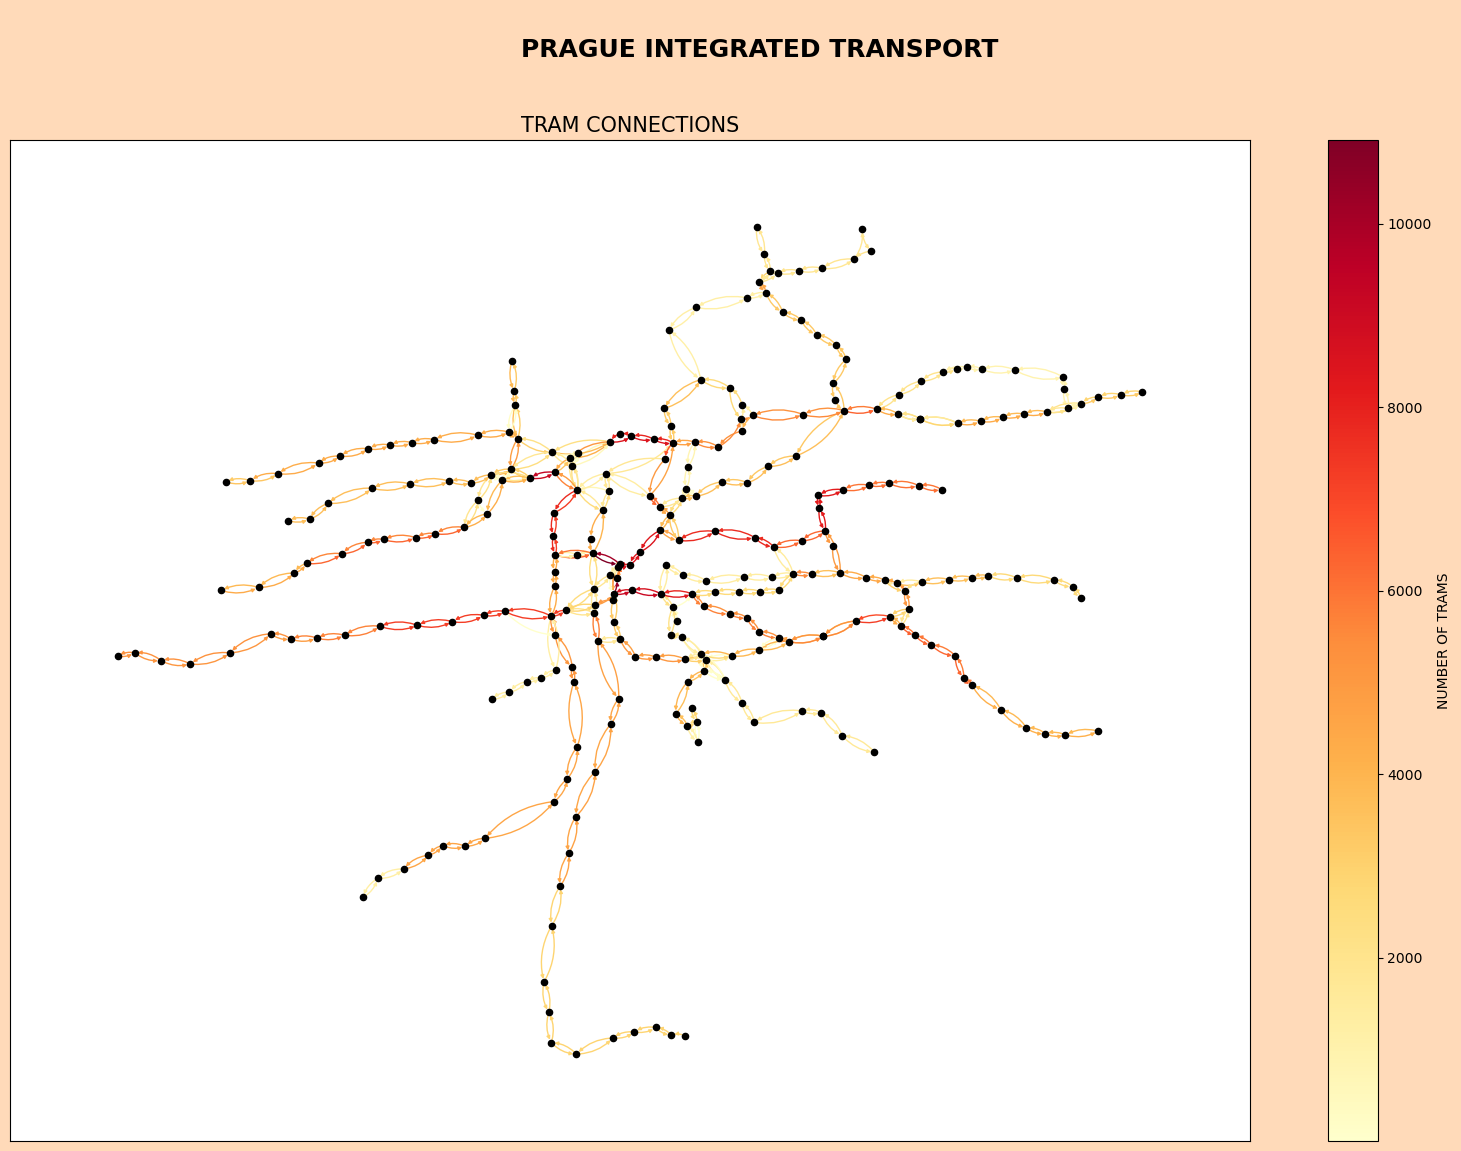

In [27]:
vmax = max ( weights )
vmin = min ( weights )
colormap = plt.cm.YlOrRd


fig, ax = plt . subplots ( figsize = (20, 13), facecolor='peachpuff' )
nx . draw_networkx_nodes ( tram_graph, 
                           pos = stop_location, 
                           nodelist = tram_nodes, 
                           node_color = 'black',
                           node_size = 20,
                         )
nx . draw_networkx_edges ( tram_graph, 
                           pos = stop_location, 
                           edgelist = tram_edges,
                           connectionstyle = 'arc3, rad = 0.2',
                           edge_cmap = colormap,
                           edge_vmin = vmin,
                           edge_vmax = vmax,
                           edge_color = weights,
                           arrowsize = 5,
                           node_size = 20,
                         )
fig . suptitle( "\nPRAGUE INTEGRATED TRANSPORT", size = 18, weight = 'black' )
plt . title( "TRAM CONNECTIONS", size = 15 )

sm = plt . cm . ScalarMappable ( cmap = colormap, norm = plt . Normalize ( vmin = vmin, vmax = vmax ) )
cbar = plt . colorbar ( sm, label = "NUMBER OF TRAMS" )

plt . show()

This graph is good, it shows the most used edges `perfectly`, but it has one `disadvantage` - the `lack of station names`. It is very difficult to add station names to this graph without making it `less readable`, as we have more than 200 stops.

Therefore, we will create another visualisation that contains fewer tram stops, but will have `names for each station`.

We will use for our visualisation the most interesting part - the `centre of Prague`. To do this, we need to find the `mean values` and `variances` of the coordinates in this graph.

In [28]:
lon = np . array ( [ value [0] for key, value in stop_location . items ( ) if key in tram_nodes ] )
lat = np . array ( [ value [1] for key, value in stop_location . items ( ) if key in tram_nodes ] )
lon_mean = lon . mean ( )
lon_std = lon . std ( )
lat_mean = lat . mean ( )
lat_std = lat . std ( )

Let's add stops and routes that are in the centre of Prague.

In [29]:
tram_middle_nodes = [ edge[0] for edge in pid_graph . edges ( data = True ) if ( edge [ 2 ] [ "type" ] == 0 ) & ( stop_location [ edge[0] ] [ 0 ] < lon_mean + lon_std ) & ( stop_location [ edge[0] ] [ 0 ] > lon_mean - lon_std ) & ( stop_location [ edge[0] ] [ 1 ] < lat_mean + lat_std ) & ( stop_location [ edge[0] ] [ 1 ] > lat_mean - lat_std - 0.005 ) ]
tram_middle_nodes += [ edge[1] for edge in pid_graph . edges ( data = True ) if ( edge [ 2 ] [ "type" ] == 0 ) & ( stop_location [ edge[1] ] [ 0 ] < lon_mean + lon_std ) & ( stop_location [ edge[1] ] [ 0 ] > lon_mean - lon_std ) & ( stop_location [ edge[1] ] [ 1 ] < lat_mean + lat_std ) & ( stop_location [ edge[1] ] [ 1 ] > lat_mean - lat_std - 0.005 ) ]
tram_middle_edges = [ edge for edge in pid_graph . edges ( data = True ) if ( edge [ 2 ] [ "type" ] == 0 ) & ( edge [0] in tram_middle_nodes ) & ( edge[1] in tram_middle_nodes ) ]
middle_weights = [ edge [ 2 ] [ "weight" ] for edge in tram_middle_edges ]
tram_middle_graph = pid_graph . subgraph ( tram_middle_nodes )

To ensure that the names of the stops do not `overlap`, `adjust their coordinates` slightly.

In [30]:
labels_location = {}
for key, value in stop_location . items ( ):
    labels_location [ key ] = value . copy ( )

In [31]:
labels_location [ "Národní divadlo" ] [ 1 ] += 0.0005
labels_location [ "Národní třída" ] [ 1 ] += 0.0005
labels_location [ "Vodičkova" ] [ 0 ] += 0.0005
labels_location [ "Strossmayerovo náměstí" ] [ 1 ] -= 0.0005
labels_location [ "Vinohradská vodárna" ] [ 1 ] -= 0.0005
labels_location [ "Krematorium Strašnice" ] [ 1 ] -= 0.0003
labels_location [ "Flora" ] [ 0 ] -= 0.0005
labels_location [ "Chodovská" ] [ 1 ] -= 0.0003
labels_location [ "Pod Karlovem" ] [ 1 ] += 0.0005
labels_location [ "Náměstí Bratří Synků" ] [ 1 ] -= 0.0008
labels_location [ "Svatoplukova" ] [ 1 ] += 0.0008 
labels_location [ "Korunovační" ] [ 1 ] += 0.0003
labels_location [ "Slavia - Nádraží Eden" ] [ 1 ] += 0.0007

Visualisation of the tram connections in `the centre o Prague`.

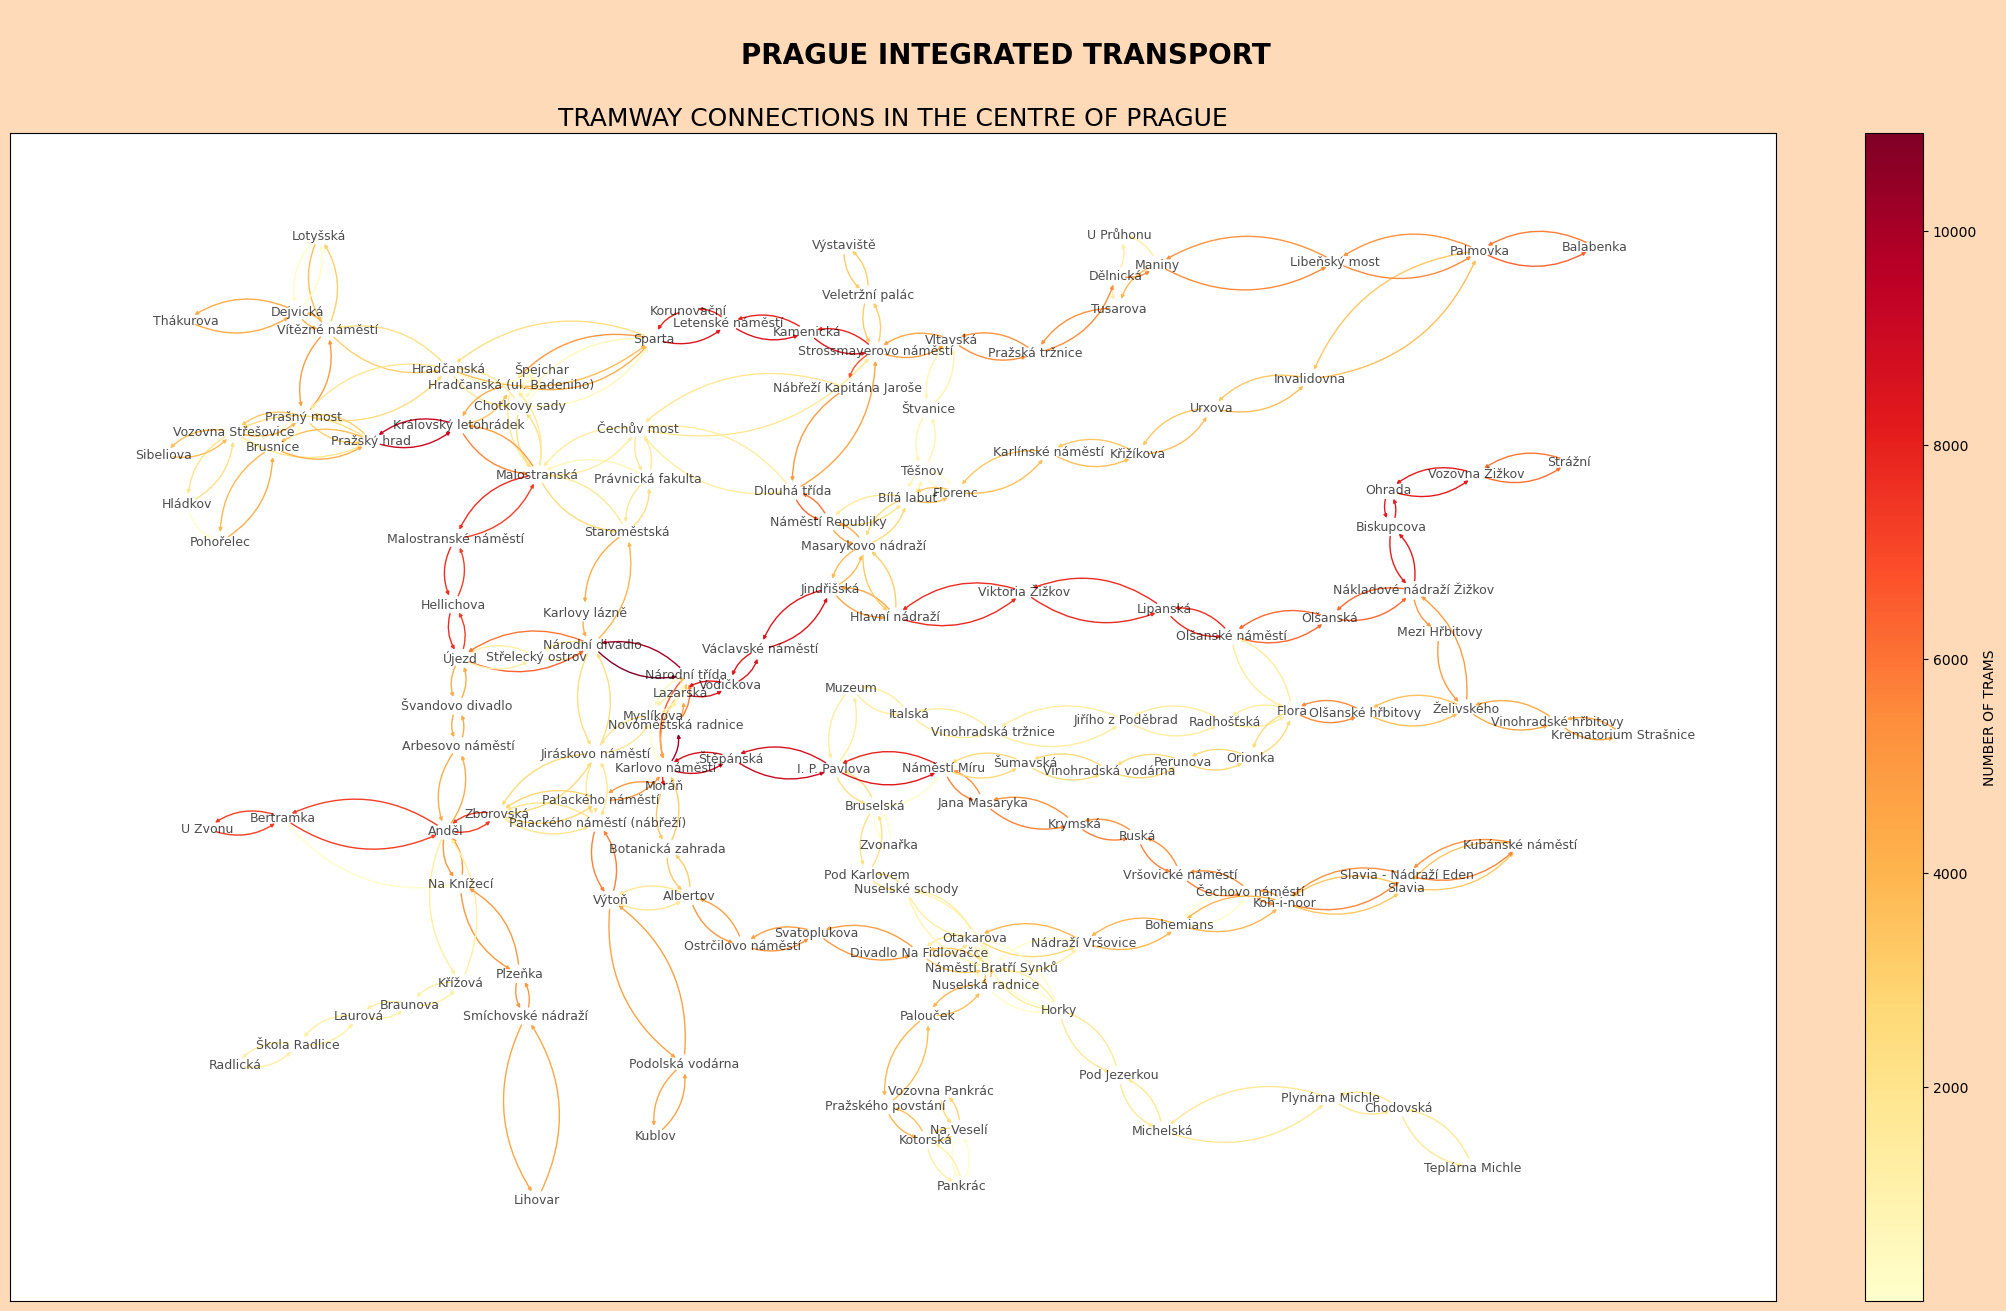

In [32]:
fig, ax = plt . subplots ( figsize = (20, 13), facecolor='peachpuff', constrained_layout = True )
nx . draw_networkx_edges ( tram_middle_graph, 
                           pos = labels_location, 
                           edgelist = tram_middle_edges,
                           connectionstyle = 'arc3, rad = 0.3',
                           edge_cmap = colormap,
                           edge_vmin = vmin,
                           edge_vmax = vmax,
                           edge_color = middle_weights,
                           arrowsize = 5,
                           node_size = 200,
                         )
nx . draw_networkx_labels ( tram_middle_graph,
                            labels_location,
                            font_size = 9,
                            alpha = 0.7
                          )
fig . suptitle( "\nPRAGUE INTEGRATED TRANSPORT", size = 20, weight = 'black' )
plt . title( "\nTRAMWAY CONNECTIONS IN THE CENTRE OF PRAGUE", size = 18 )

sm = plt . cm . ScalarMappable ( cmap = colormap, norm = plt . Normalize ( vmin = vmin, vmax = vmax ) )
cbar = plt . colorbar ( sm, label = "NUMBER OF TRAMS" )

plt . show()

## Centrality measures

A couple of `notes` to start with:
* In this assignment we are working with a `directed weighted graph`. All centrality measures, that we have on lecture, have been defined for `non-weighted graphs` and their documentation is silent on the differences in working with weighted graphs. So they will `not give us any additional information about the weights`.
* To get some information about the weights of the graph we will use the `degree` function.
* Еhe best way to work with the information we get from these `centrality measures` is to work with their `visualisations`, so I will create a visualisation for each graph and then `analyse` it.
* Due to the fact that our full graph has `several thousand stops`, I will work with its `subgraph`, namely the `tram stations`. 

First, let's find out the `most` and `least` popular stops in Prague.

In [33]:
pid_deg = pid_graph . degree ( weight = 'weight' )
pid_deg_map = {}
for node in pid_deg:
    pid_deg_map [ node [0] ] = node [1]
pid_deg_max = max ( pid_deg_map, key = pid_deg_map . get )
pid_deg_min = min ( pid_deg_map, key = pid_deg_map . get )
print ( "The most frequented traffic stop in Prague is", "%s,"%(pid_deg_max) , int ( pid_deg_map [ pid_deg_max ] ), "different vehicles pass this stop in a week." )
print ( "The least frequented traffic stop in Prague is", "%s,"%(pid_deg_min) , int ( pid_deg_map [ pid_deg_min ] ), "different vehicles pass this stop in a week." )

The most frequented traffic stop in Prague is Anděl, 69827 different vehicles pass this stop in a week.
The least frequented traffic stop in Prague is Kostelec n.Vlt.,Sobědraž,rozc.s.19, 2 different vehicles pass this stop in a week.


Function `degree_centrality` will count the `amount of connections` for each transport stop. 

In [34]:
pid_deg_cen = nx . degree_centrality ( pid_graph )
max_pid_deg_cen = max ( pid_deg_cen, key = pid_deg_cen . get )
max_pid_deg_cen_neighbours = set ( )
for edge in pid_graph . edges ( ):
    if edge[0] == max_pid_deg_cen:
        max_pid_deg_cen_neighbours . add ( edge[1] )
    elif edge[1] == max_pid_deg_cen:
        max_pid_deg_cen_neighbours . add ( edge[0] )
print ( "The stop with the most transport connections:", "%s, it has"%(max_pid_deg_cen), len ( max_pid_deg_cen_neighbours ), "connections." )

The stop with the most transport connections: Lihovar, it has 16 connections.


Now let's work only with `tram connections` (reasons are above).

Create a `subgraph` based on tram links.

In [35]:
subgraph_on_edges = pid_graph . edge_subgraph ( [ ( from_, to, attr ["type"] )  for ( from_, to, attr ) in pid_graph . edges ( data = True ) if attr [ "type" ] == 0 ] )

In [36]:
tram_deg = subgraph_on_edges . degree ( weight = 'weight' )
tram_deg_map = {}
for node in tram_deg:
    tram_deg_map [ node [0] ] = node [1]
tram_deg_max = max ( tram_deg_map, key = tram_deg_map . get )
tram_deg_min = min ( tram_deg_map, key = tram_deg_map . get )
print ( "The most frequented tram stop in Prague is", "%s,"%(tram_deg_max) , int ( tram_deg_map [ tram_deg_max ] ), "trams pass this stop in a week." )
print ( "The least frequented tram stop in Prague is", "%s,"%(tram_deg_min) , int ( tram_deg_map [ tram_deg_min ] ), "trams pass this stop in a week." )

The most frequented tram stop in Prague is Karlovo náměstí, 55236 trams pass this stop in a week.
The least frequented tram stop in Prague is Zvonařka, 28 trams pass this stop in a week.


Create a function, that will draw `visualisations` for centrality mesures.

In [37]:
def draw ( G, pos, edges, centrality, maximum, minimum, centrality_name ):
    
    vmax = maximum
    vmin = minimum
    colormap = plt.cm.inferno
    
    fig, ax = plt . subplots ( figsize = (20, 13) )
    
    nx . draw_networkx_nodes ( G,
                               pos,
                               node_size = 50,
                               nodelist = centrality . keys ( ),
                               cmap = colormap,
                               vmin = vmin,
                               vmax = vmax,
                               node_color = list ( centrality . values ( ) ) 
                             )
    edges = nx.draw_networkx_edges ( G,
                                     pos,
                                     edgelist = edges,
                                     node_size = 50,
                                     arrowsize = 0.001
                                   )

    plt.title ( centrality_name )
    sm = plt . cm . ScalarMappable ( cmap = colormap, norm = plt . Normalize ( vmin = vmin, vmax = vmax ) )
    cbar = plt . colorbar ( sm )

    plt.show()

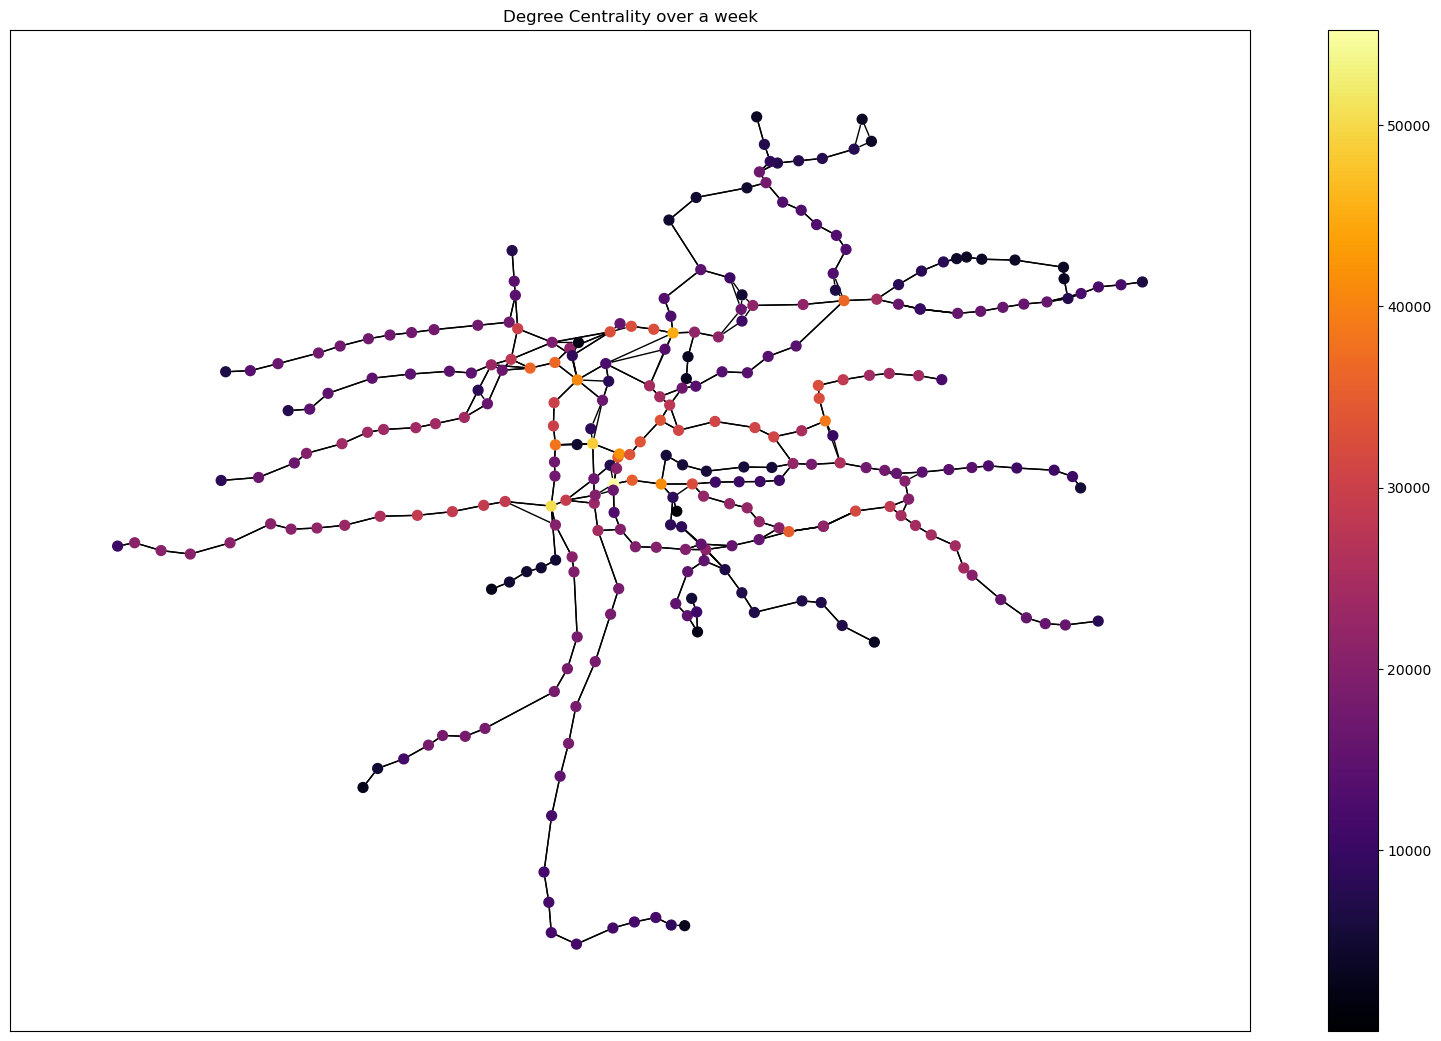

In [38]:
draw ( tram_graph, stop_location, tram_edges, tram_deg_map, tram_deg_map[ tram_deg_max ], tram_deg_map[ tram_deg_min ], "Degree Centrality over a week" )

This graph shows which stops were passed by the `most trams during the week`. With it we can understand the importance of each stop, i.e. where the `main flow of people` is (there will be the most expensive advertising, for example). It is not surprising that the most frequented stops in Prague are in the `city centre`.

In [39]:
tram_deg_cen = nx . degree_centrality ( tram_graph )
max_tram_deg_cen = max ( tram_deg_cen, key = tram_deg_cen . get )
min_tram_deg_cen = min ( tram_deg_cen, key = tram_deg_cen . get )
max_tram_deg_cen_neighbours = set ( )
for edge in pid_graph . edges ( data = True ):
    if edge[2]["type"] == 0:
        if edge[0] == max_tram_deg_cen:
            max_tram_deg_cen_neighbours . add ( edge[1] )
        elif edge[1] == max_tram_deg_cen:
            max_tram_deg_cen_neighbours . add ( edge[0] )
print ( "The stop with the most tram connections:", "%s, it has"%(max_tram_deg_cen), len ( max_tram_deg_cen_neighbours ), "connections." )

The stop with the most tram connections: Anděl, it has 5 connections.


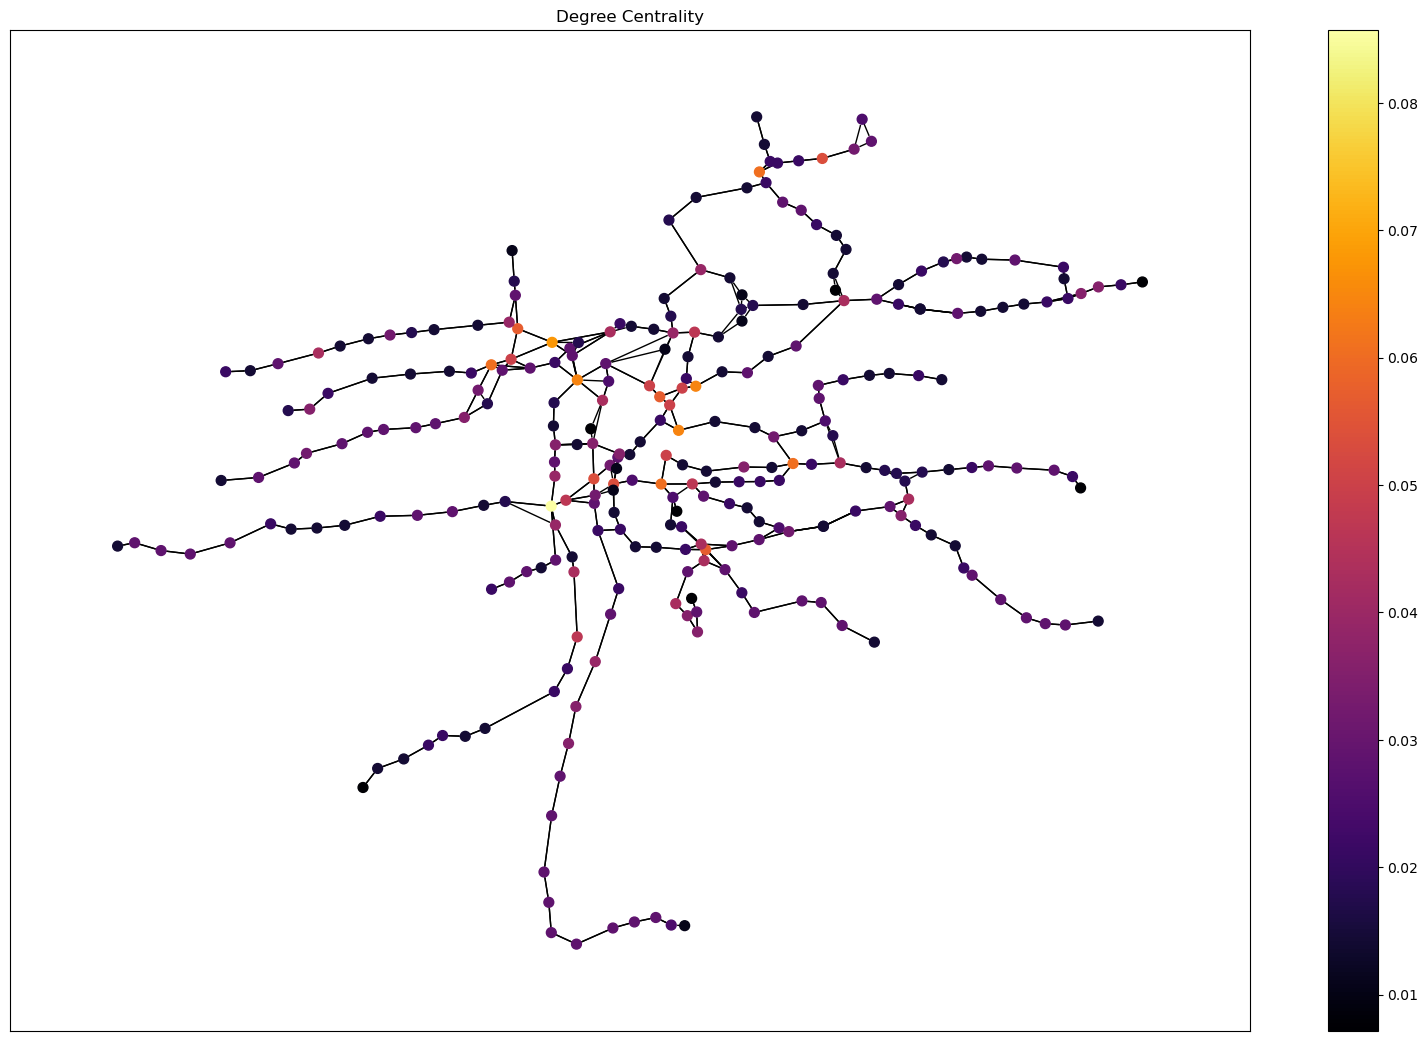

In [40]:
draw ( tram_graph, stop_location, tram_edges, tram_deg_cen, tram_deg_cen[ max_tram_deg_cen ], tram_deg_cen[ min_tram_deg_cen ], "Degree Centrality" )

This graph shows which stops have the most connections. That means, that they are `transport interchanges`. Overally, this information tells us the same thing as the previous visualisation - the `importance of stops`. Nodes with more connections are more influential and important in a network.

In [41]:
tram_clos_cen = nx . closeness_centrality ( tram_graph )
max_tram_clos_cen = max ( tram_clos_cen, key = tram_clos_cen . get )
min_tram_clos_cen = min ( tram_clos_cen, key = tram_clos_cen . get )
print ( "The stop with the shortest average distance with other stops:", max_tram_clos_cen )

The stop with the shortest average distance with other stops: I. P. Pavlova


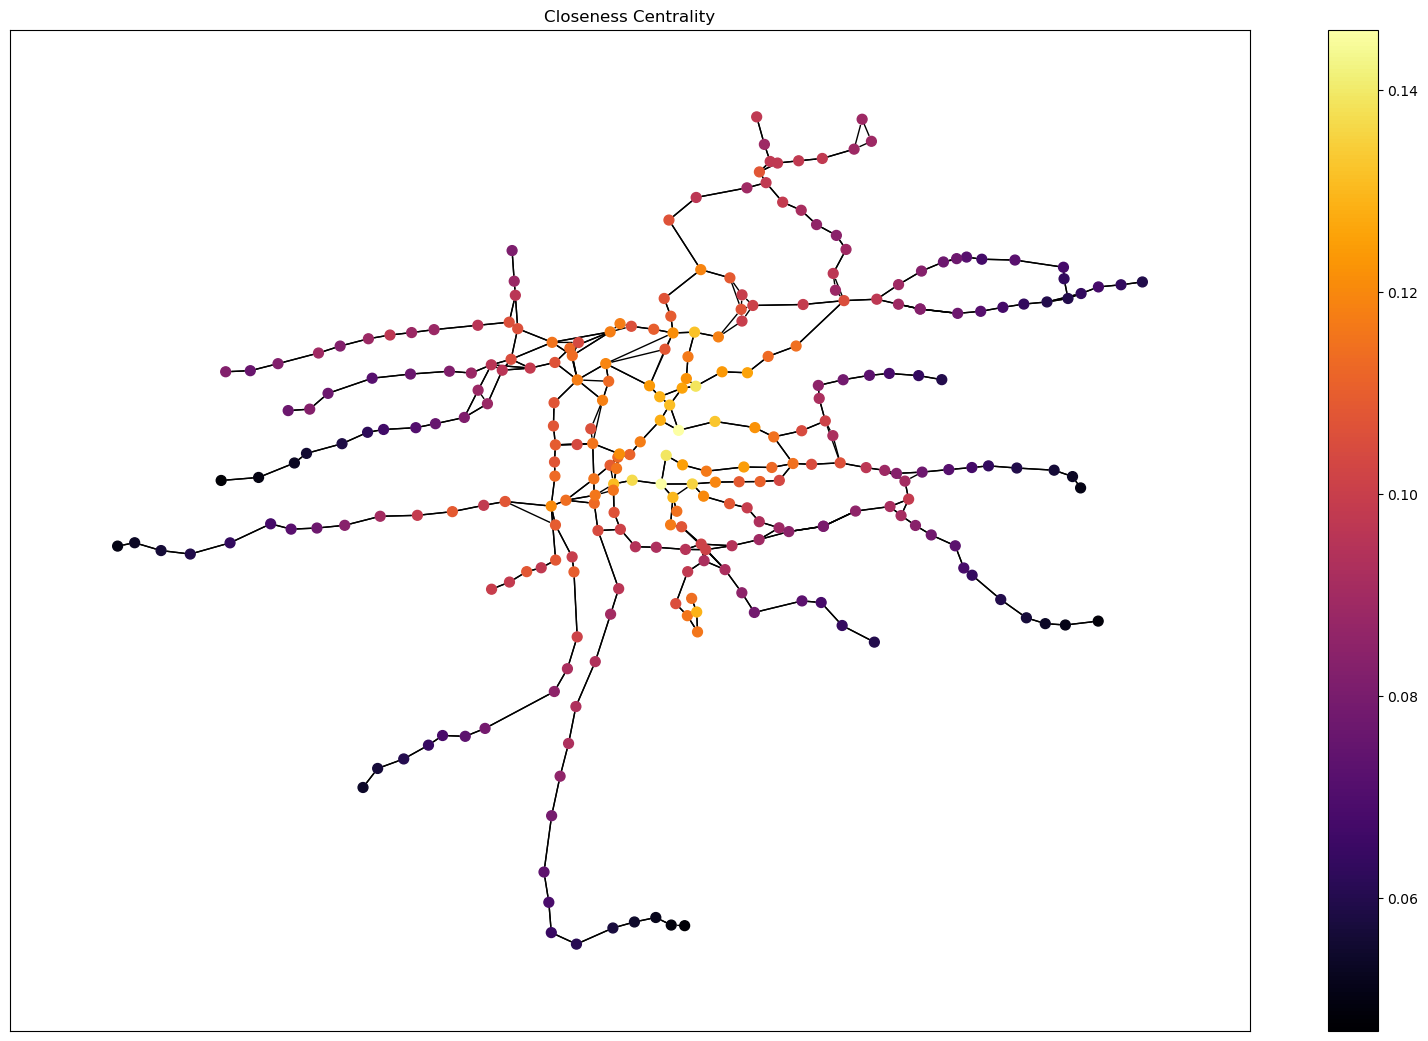

In [42]:
draw ( tram_graph, stop_location, tram_edges, tram_clos_cen, tram_clos_cen[ max_tram_clos_cen ], tram_clos_cen[ min_tram_clos_cen ], "Closeness Centrality" )

Closeness centrality is a measure where each node’s importance is determined by `closeness to all other nodes`. Thus, the more central a node is, the closer it is to all other nodes. This visualisation show us, `where is located the centre of` Prague's entire `tram system`. As we can see, it is a little `to the right` of the most popular stops.

In [43]:
tram_bet_cen = nx . betweenness_centrality ( tram_graph )
max_tram_bet_cen = max ( tram_bet_cen, key = tram_bet_cen . get )
min_tram_bet_cen = min ( tram_bet_cen, key = tram_bet_cen . get )
print ( "The biggest number of the shortest paths passing by:", max_tram_bet_cen )

The biggest number of the shortest paths passing by: Hlavní nádraží


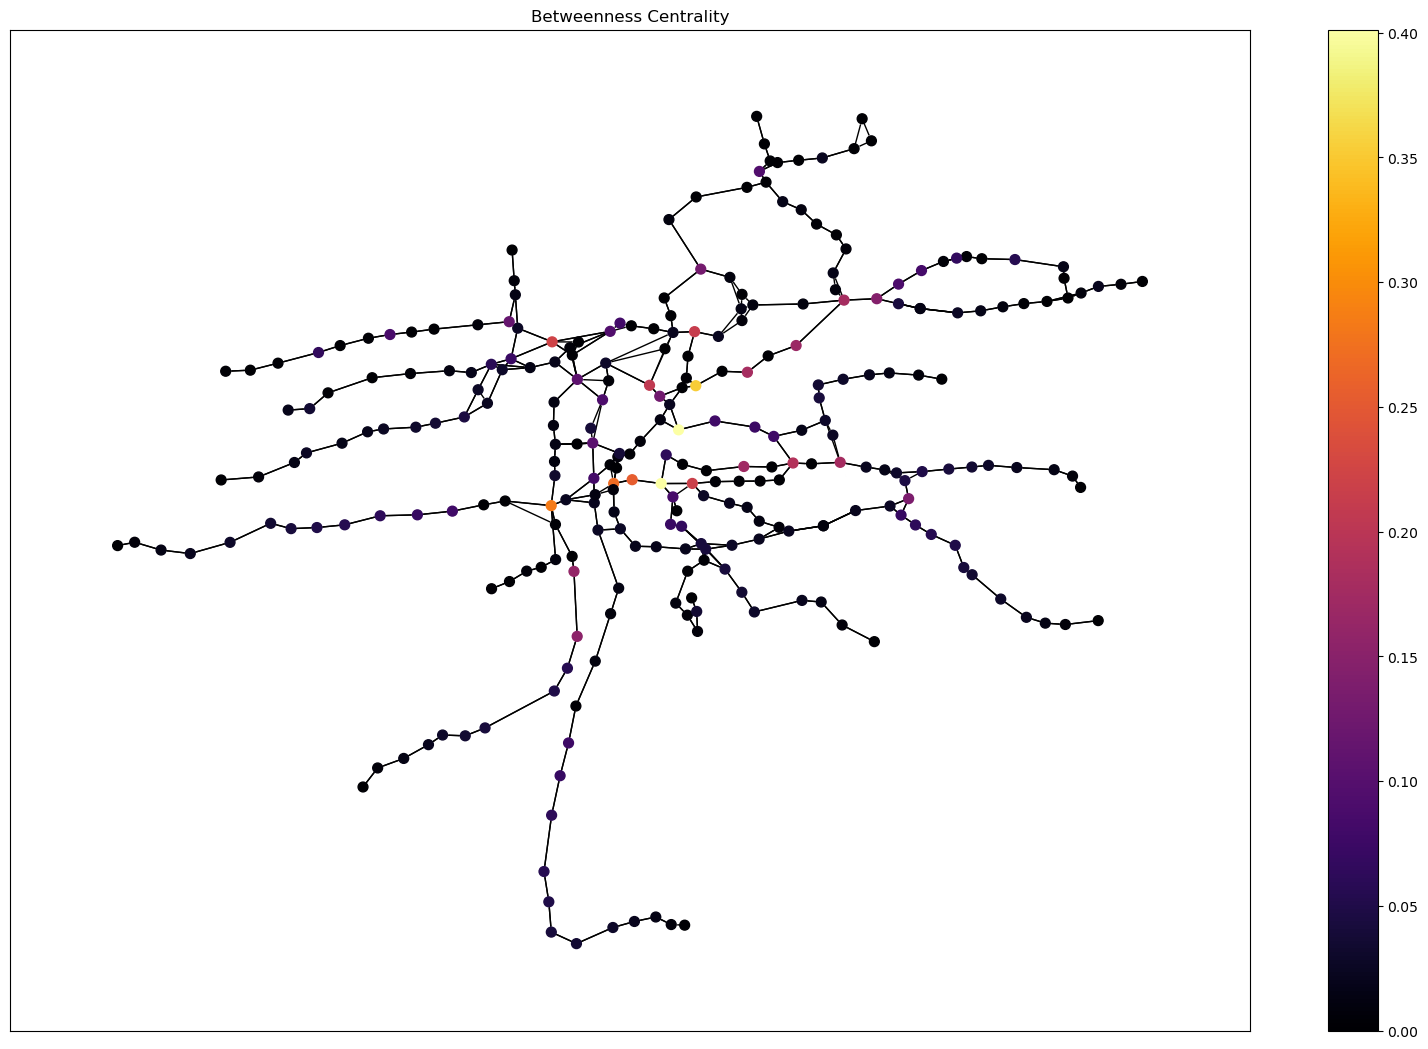

In [44]:
draw ( tram_graph, stop_location, tram_edges, tram_bet_cen, tram_bet_cen[ max_tram_bet_cen ], tram_bet_cen[ min_tram_bet_cen ], "Betweenness Centrality" )

Betweenness Centrality is determined as number of the shortest paths passing by the given node. This means that this stop does `not` always `have the biggest traffic`, but this stop is often `on the way` from one location to another. Not surprisingly, in Prague such a stop is the `main railway station`, because we don't get off at the railway every day, but everything should be as close to the railway station as possible. This tells us that the planners of Prague's tram network did a good job.

## Questions

### 1) What is the shortest route between stops Koleje Strahov and Hloubětín? If there are several such routes, choose the most popular one ( the one with the most traffic during the week ).

Firstly, use the function `all_shrotest_paths` to find all paths from station *Koleje Strahov* to station *Hloubětín*, that have the `least number` of stops on their route.

In [45]:
routes = list ( nx . all_shortest_paths ( pid_graph, "Koleje Strahov", "Hloubětín" ) )
routes

[['Koleje Strahov',
  'Malovanka',
  'Hládkov',
  'Vozovna Střešovice',
  'Letňany',
  'Prosek',
  'Vysočanská',
  'Kolbenova',
  'Hloubětín'],
 ['Koleje Strahov',
  'Malovanka',
  'Hládkov',
  'Vozovna Střešovice',
  'Letňany',
  'Čakovická',
  'Nový Hloubětín',
  'Kolbenova',
  'Hloubětín'],
 ['Koleje Strahov',
  'Malovanka',
  'Hládkov',
  'Vozovna Střešovice',
  'Letňany',
  'Čakovická',
  'Nový Hloubětín',
  'Kbelská',
  'Hloubětín']]

As we can see, we have `3 paths` with the same length. Let's find the one with the `most traffic during the week`.

In [46]:
route_weight = { }
for i, route in enumerate ( routes ):
    route_weight [ i ] = 0
    for j in range ( len ( route ) - 1 ):
        for k in pid_graph . get_edge_data ( route [ j ], route [ j + 1 ] ) . values ( ):
            route_weight [ i ] += k [ "weight" ] 
print ( "Weight of path 1:", route_weight[0], "\nWeight of path 2:", route_weight[1], "\nWeight of path 3:", route_weight[2] )
best_route = max ( route_weight, key = route_weight . get )
print ( "The best route for the given conditions:", routes [ best_route ] )

Weight of path 1: 15343.0 
Weight of path 2: 10874.0 
Weight of path 3: 13034.0
The best route for the given conditions: ['Koleje Strahov', 'Malovanka', 'Hládkov', 'Vozovna Střešovice', 'Letňany', 'Prosek', 'Vysočanská', 'Kolbenova', 'Hloubětín']


We have found the `best path`, now let's visualise it. 

Create a `subgraph` of our graph, which will contain all stops from the best route as well as neighbouring stops.

In [47]:
str_hloub_nodes = set( [ edge[0] for edge in pid_graph . edges ( data = True ) if ( edge [ 0 ] in routes [ best_route ] ) | ( edge [ 1 ] in routes [ best_route ] ) ] )
str_hloub_nodes . update ( [ edge[1] for edge in pid_graph . edges ( data = True ) if ( edge [ 0 ] in routes [ best_route ] ) | ( edge [ 1 ] in routes [ best_route ] ) ] )
str_hloub_edges = [ edge for edge in pid_graph . edges ( data = True ) if ( edge [ 0 ] in str_hloub_nodes ) & ( edge [ 1 ] in str_hloub_nodes ) ]

In [48]:
str_hloub_graph = pid_graph . subgraph ( str_hloub_nodes )

To ensure that the names of the stops do not `overlap`, `adjust their coordinates` slightly.

In [49]:
str_hloub_locations = {}
for key, value in stop_location . items ( ):
    str_hloub_locations [ key ] = value . copy ( )

In [50]:
str_hloub_locations [ "Vysočanská" ] [ 1 ] -= 0.0015
str_hloub_locations [ "Prosek" ] [ 1 ] -= 0.0007
str_hloub_locations [ "Prosek" ] [ 0 ] += 0.0013
str_hloub_locations [ "Hloubětín" ] [ 1 ] += 0.0007
str_hloub_locations [ "Hládkov" ] [ 1 ] -= 0.0007
str_hloub_locations [ "Hládkov" ] [ 0 ] += 0.0013
str_hloub_locations [ "Malovanka" ] [ 1 ] -= 0.0007
str_hloub_locations [ "Malovanka" ] [ 0 ] += 0.0013
str_hloub_locations [ "Letňany" ] [ 1 ] -= 0.0007
str_hloub_locations [ "Letňany" ] [ 0 ] += 0.0013
str_hloub_locations [ "Koleje Strahov" ] [ 1 ] -= 0.0007
str_hloub_locations [ "Koleje Strahov" ] [ 0 ] += 0.0013
str_hloub_locations [ "Vozovna Střešovice" ] [ 1 ] += 0.0008
str_hloub_locations [ "Vozovna Střešovice" ] [ 0 ] -= 0.01

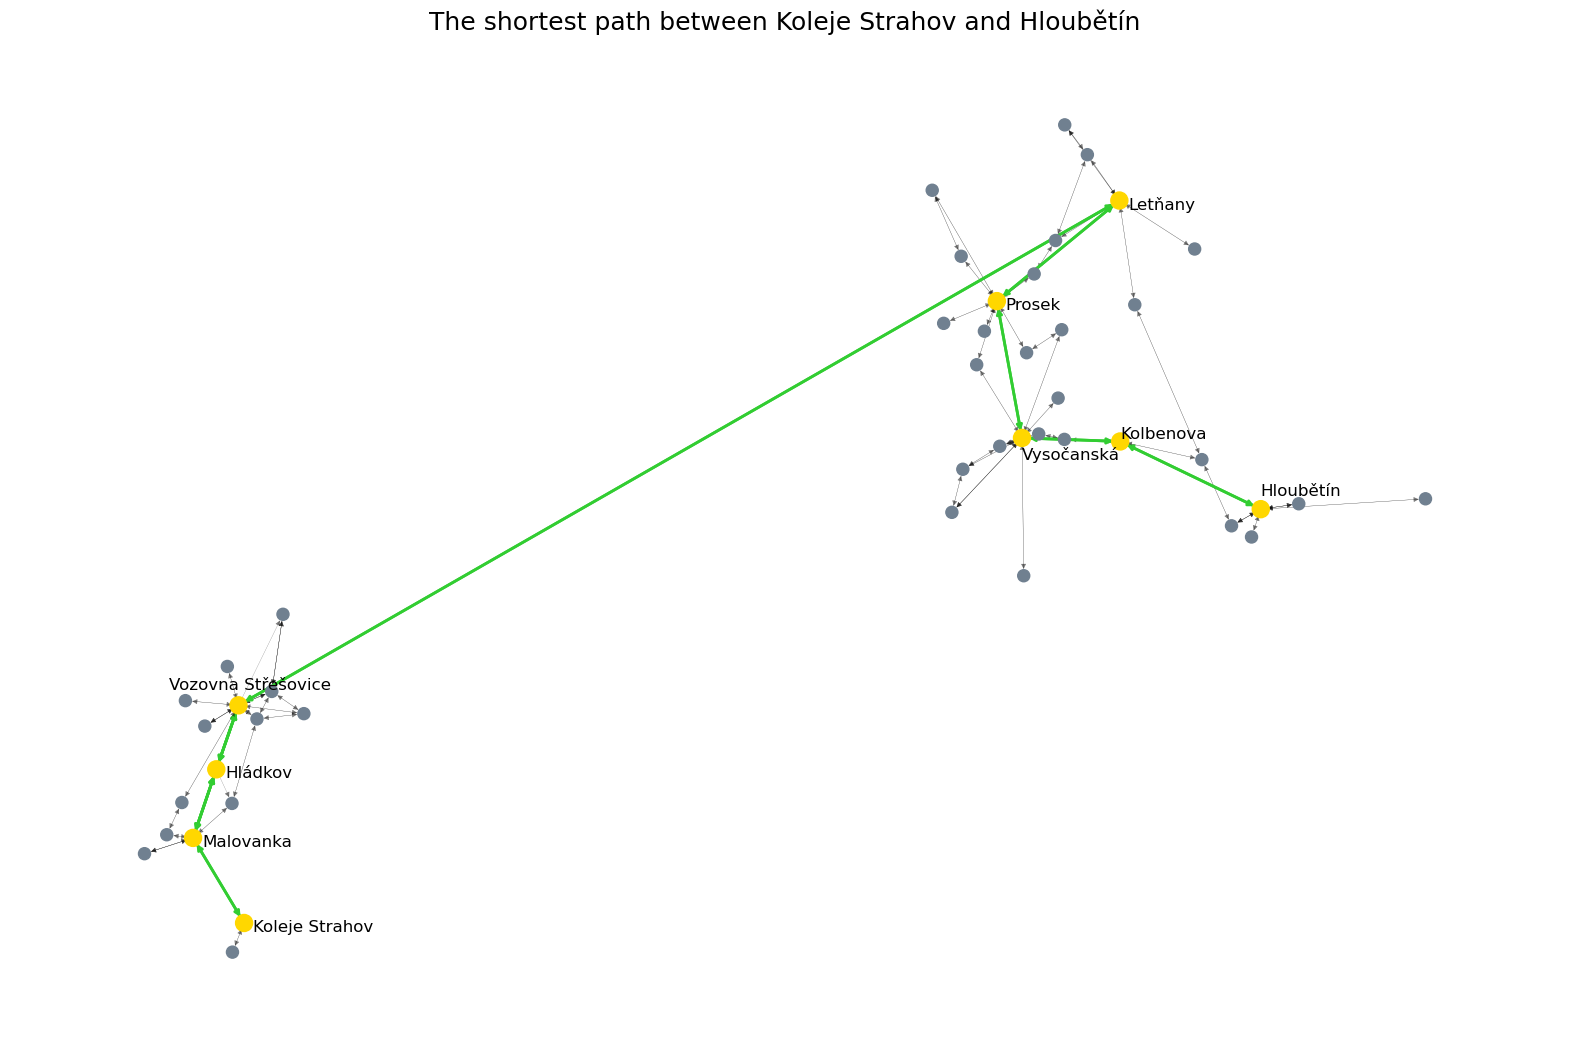

In [51]:
fig, ax = plt . subplots ( figsize = (20, 13) )
nx . draw_networkx_nodes ( str_hloub_graph, 
                           pos = stop_location, 
                           nodelist = str_hloub_nodes, 
                           node_color = [ 'gold' if node in routes [ best_route ] else 'slategray' for node in str_hloub_nodes ],
                           node_size = [ 150 if node in routes [ best_route ] else 75 for node in str_hloub_nodes ]
                         )
nx . draw_networkx_edges ( str_hloub_graph, 
                           pos = stop_location, 
                           edgelist = str_hloub_edges,
                           arrowsize = 8,
                           edge_color = [ 'limegreen' if ( edge[0] in routes [ best_route ] ) & ( edge[1] in routes [ best_route ] ) else 'black' for edge in str_hloub_edges ],
                           node_size = 100,
                           width = [ 2 if ( edge[0] in routes [ best_route ] ) & ( edge[1] in routes [ best_route ] ) else 0.2 for edge in str_hloub_edges ],
                           alpha = [ 1 if ( edge[0] in routes [ best_route ] ) & ( edge[1] in routes [ best_route ] ) else 0.5 for edge in str_hloub_edges ],
                         )
nx . draw_networkx_labels ( str_hloub_graph,
                            str_hloub_locations,
                            labels = { node: node for node in str_hloub_graph . nodes ( ) if node in routes [ best_route ] },
                            font_size = 12,
                            alpha = 1,
                            horizontalalignment = 'left',
                            verticalalignment = 'bottom'
                          )
plt . title( "The shortest path between Koleje Strahov and Hloubětín", size = 18 )
plt . axis("off")

plt . show()

### 2) Which stop has the highest number of different types of transport passing through?

Let's count the `amount of traffic` that passes through the each stop.

In [52]:
types_of_transport = {}
amount_of_types = {}
for node in pid_graph . nodes ( ):
    types_of_transport [ node ] = set ( )
    amount_of_types [ node ] = 0
for edge in pid_graph . edges ( ):
    for transport in pid_graph . get_edge_data ( edge [0], edge [1] ) . values ( ):
        types_of_transport [ edge [0] ] . add ( transport["type"] )
        amount_of_types [ edge [0] ] += 1
        types_of_transport [ edge [1] ] . add ( transport["type"] )
        amount_of_types [ edge [1] ] += 1

Find the `biggest value` in our set.

In [53]:
types_max = max ( amount_of_types, key = amount_of_types . get )
set_len = len ( types_of_transport [ types_max ] )
print ( "Route_types:", types_of_transport [ types_max ] )
print ( "The highest number of different types of transport passing through the stop:", set_len )

Route_types: {0, 1, 3}
The highest number of different types of transport passing through the stop: 3


The highest score is three, obviously there is `more than one` such stop in Prague. Let's print all of them. 

In [54]:
max_len_nodes = []
for node, value in types_of_transport . items ( ):
    if len ( value ) == set_len:
        max_len_nodes . append ( node )
display ( max_len_nodes )

['Smíchovské nádraží',
 'Anděl',
 'Hloubětín',
 'Karlovo náměstí',
 'Pražského povstání',
 'Lihovar',
 'Palmovka',
 'Staroměstská',
 'Muzeum',
 'Radlická',
 'Dvorce',
 'Želivského',
 'Ládví',
 'Depo Hostivař',
 'Nádraží Holešovice',
 'Hradčanská',
 'Jiřího z Poděbrad',
 'Nádraží Modřany',
 'Dejvická',
 'Nádraží Veleslavín',
 'Florenc',
 'Náměstí Republiky',
 'Petřiny',
 'Újezd',
 'Hlavní nádraží',
 'Kobylisy',
 'Bořislavka',
 'Strašnická',
 'Vltavská',
 'Flora',
 'Vysočanská',
 'Pankrác',
 'Malostranská',
 'Náměstí Míru',
 'I. P. Pavlova']

Now let's visualise theses stops and all connections with them. To do this we will use another `subgraph`, which we will create below.

In [55]:
diff_types_nodes = set( [ edge[0] for edge in pid_graph . edges ( data = True ) if ( ( edge [ 0 ] in max_len_nodes ) | ( edge [ 1 ] in max_len_nodes ) ) & ( stop_location [ edge[0] ] [ 0 ] < lon_mean + 4*lon_std ) & ( stop_location [ edge[0] ] [ 0 ] > lon_mean - 3*lon_std ) & ( stop_location [ edge[0] ] [ 1 ] < lat_mean + 4*lat_std ) & ( stop_location [ edge[0] ] [ 1 ] > lat_mean - 4*lat_std ) ] )
diff_types_nodes . update ( [ edge[1] for edge in pid_graph . edges ( data = True ) if ( ( edge [ 0 ] in max_len_nodes ) | ( edge [ 1 ] in max_len_nodes ) ) & ( stop_location [ edge[1] ] [ 0 ] < lon_mean + 4*lon_std ) & ( stop_location [ edge[1] ] [ 0 ] > lon_mean - 3*lon_std ) & ( stop_location [ edge[1] ] [ 1 ] < lat_mean + 4*lat_std ) & ( stop_location [ edge[1] ] [ 1 ] > lat_mean - 4*lat_std ) ] )
tram_edges = [ edge for edge in pid_graph . edges ( data = True ) if ( edge [ 0 ] in diff_types_nodes ) & ( edge [ 1 ] in diff_types_nodes ) & ( ( edge[0] in max_len_nodes ) | ( edge[1] in max_len_nodes ) ) & ( edge [ 2 ] [ "type" ] == 0 ) ]
subway_edges = [ edge for edge in pid_graph . edges ( data = True ) if ( edge [ 0 ] in diff_types_nodes ) & ( edge [ 1 ] in diff_types_nodes ) & ( ( edge[0] in max_len_nodes ) | ( edge[1] in max_len_nodes ) )  & ( edge [ 2 ] [ "type" ] == 1 ) ]
rail_edges = [ edge for edge in pid_graph . edges ( data = True ) if ( edge [ 0 ] in diff_types_nodes ) & ( edge [ 1 ] in diff_types_nodes ) & ( ( edge[0] in max_len_nodes ) | ( edge[1] in max_len_nodes ) ) & ( edge [ 2 ] [ "type" ] == 2 ) ]
bus_edges = [ edge for edge in pid_graph . edges ( data = True ) if ( edge [ 0 ] in diff_types_nodes ) & ( edge [ 1 ] in diff_types_nodes ) & ( ( edge[0] in max_len_nodes ) | ( edge[1] in max_len_nodes ) ) & ( edge [ 2 ] [ "type" ] == 3 ) ]
ferry_edges = [ edge for edge in pid_graph . edges ( data = True ) if ( edge [ 0 ] in diff_types_nodes ) & ( edge [ 1 ] in diff_types_nodes ) & ( ( edge[0] in max_len_nodes ) | ( edge[1] in max_len_nodes ) ) & ( edge [ 2 ] [ "type" ] == 4 ) ]
funicular_edges = [ edge for edge in pid_graph . edges ( data = True ) if ( edge [ 0 ] in diff_types_nodes ) & ( edge [ 1 ] in diff_types_nodes ) & ( ( edge[0] in max_len_nodes ) | ( edge[1] in max_len_nodes ) ) & ( edge [ 2 ] [ "type" ] == 7 ) ]
diff_types_graph = pid_graph . subgraph ( diff_types_nodes )

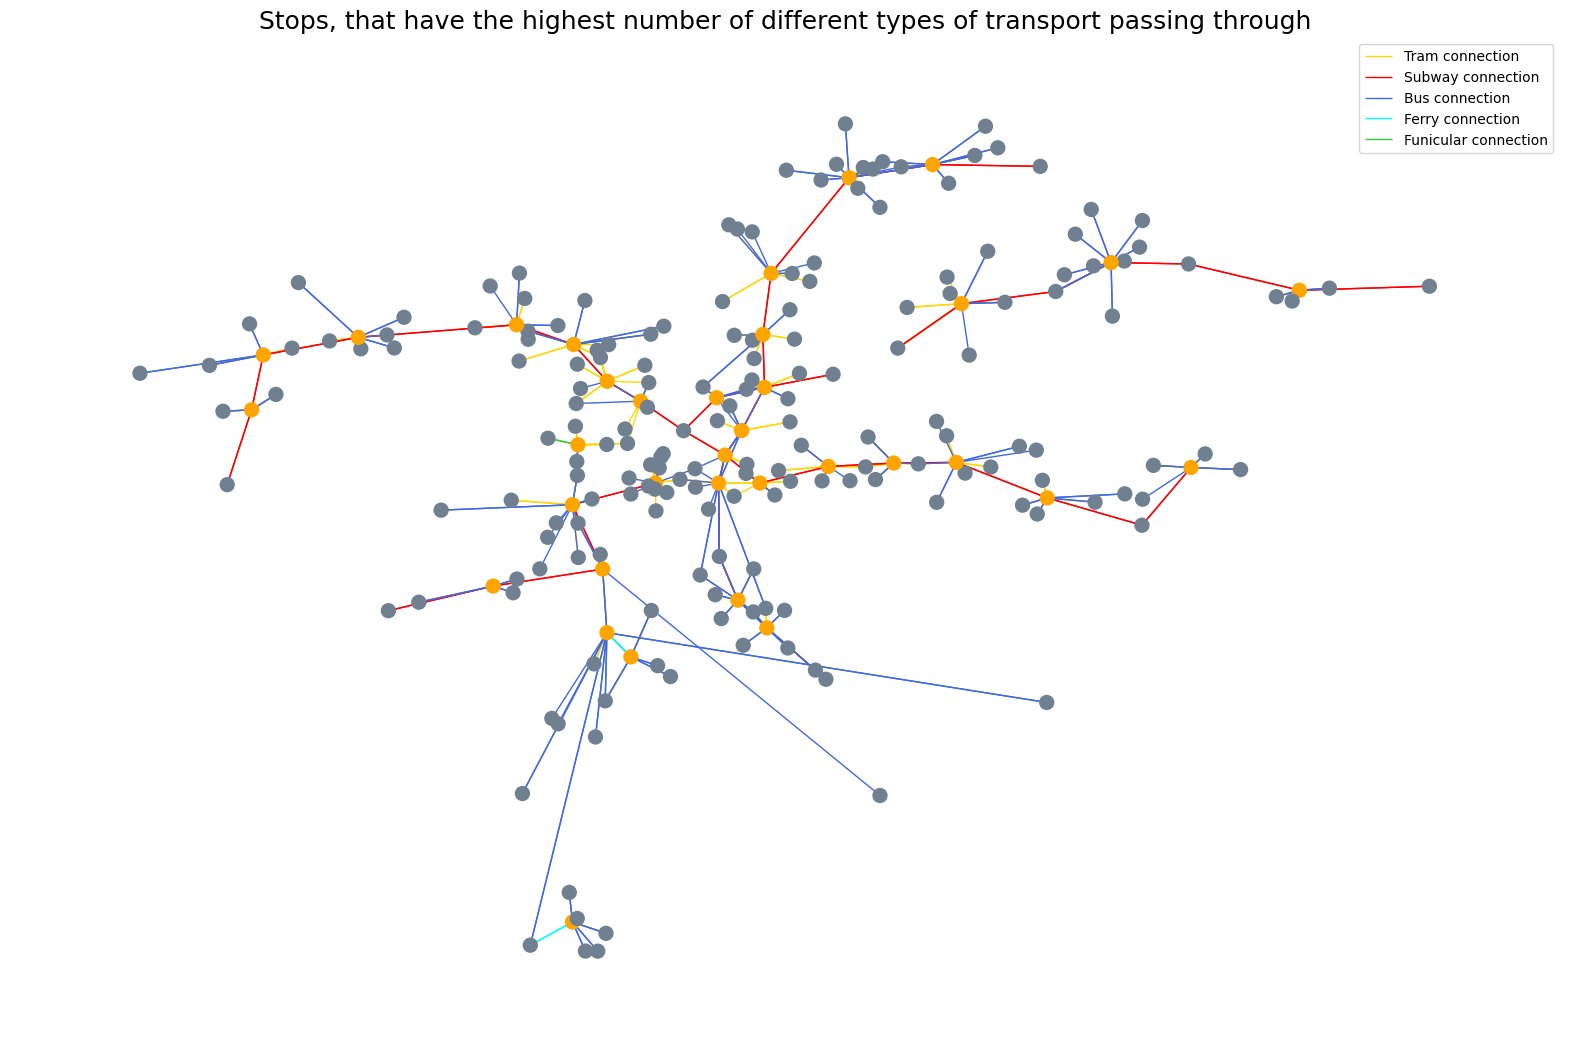

In [56]:
fig, ax = plt . subplots ( figsize = (20, 13) )
nx . draw_networkx_nodes ( diff_types_graph, 
                           pos = stop_location, 
                           nodelist = diff_types_nodes, 
                           node_color = [ 'orange' if node in max_len_nodes else 'slategray' for node in diff_types_nodes ],
                           node_size = 100
                         )
nx . draw_networkx_edges ( diff_types_graph, 
                           pos = stop_location, 
                           edgelist = tram_edges,
                           edge_color = "gold",
                           label = "Tram connection",
                           arrows = False,
                           node_size = 100,
                         )
nx . draw_networkx_edges ( diff_types_graph, 
                           pos = stop_location, 
                           edgelist = subway_edges,
                           edge_color = "red",
                           label = "Subway connection",
                           arrows = False,
                           node_size = 100,
                         )
nx . draw_networkx_edges ( diff_types_graph, 
                           pos = stop_location, 
                           edgelist = rail_edges,
                           edge_color = "black",
                           label = "Rail connection",
                           arrows = False,
                           node_size = 100,
                         )
nx . draw_networkx_edges ( diff_types_graph, 
                           pos = stop_location, 
                           edgelist = bus_edges,
                           edge_color = "royalblue",
                           label = "Bus connection",
                           arrows = False,
                           node_size = 100,
                         )
nx . draw_networkx_edges ( diff_types_graph, 
                           pos = stop_location, 
                           edgelist = ferry_edges,
                           edge_color = "aqua",
                           label = "Ferry connection",
                           arrows = False,
                           node_size = 100,
                         )
nx . draw_networkx_edges ( diff_types_graph, 
                           pos = stop_location, 
                           edgelist = funicular_edges,
                           edge_color = "limegreen",
                           label = "Funicular connection",
                           arrows = False,
                           node_size = 100,
                         )
plt . title( "Stops, that have the highest number of different types of transport passing through", size = 18 )
plt . legend ( )
plt . axis("off")

plt . show()

### 3) What Prague looks like on a Friday night? Which stops are the most popular at this time?

Count the number of times a vehicle passes between two stops during the `friday night`.

In [57]:
friday_night = data_for_graph = pid[ ( pid["friday"] == 1 ) & ( pid["is_night"] == 1 ) ][ ["stop_from_name", "stop_to_name", "route_type", "friday"] ] . groupby ( ["stop_from_name", "stop_to_name", "route_type"] ) . count ( )
friday_night

friday
stop_from_name stop_to_name         route_type        
Albertov       Botanická zahrada    0               35
               Ostrčilovo náměstí   0               39
Amforová       Luka                 3               22
               Raichlova            3                4
               Velká Ohrada         3                9
...                                                ...
Želivského     Olšanské hřbitovy    0               40
               Vinohradské hřbitovy 0               18
Ženské domovy  Anděl                3                4
Žákovská       Lysolaje             3               12
               Pod Hájem            3                4

[2014 rows x 1 columns]

Now let's create another `graph for this data`:

* Add *graph nodes* and their *attributes* ( `weight` ). 
* Add *edges* and their *attributes* ( `route type` ).

In [58]:
fr_n_graph = nx . MultiDiGraph ( )
fr_n_stops = {}
night_types = set ( )
for index, fr_n_count in friday_night . iterrows ( ):
    if index[0] in fr_n_stops:
        fr_n_stops [ index[0] ] += fr_n_count["friday"]
    else:
        fr_n_stops [ index[0] ] = fr_n_count["friday"]
    if index[1] in fr_n_stops:
        fr_n_stops [ index[1] ] += fr_n_count["friday"]
    else:
        fr_n_stops [ index[1] ] = fr_n_count["friday"]
    fr_n_graph . add_edge ( 
        index[0],
        index[1],
        type = index[2]
    )
    night_types . add ( index[2] )

In [59]:
for key, value in fr_n_stops . items ( ):
    fr_n_graph . add_node (
        key,
        weight = value
    )

There are only two modes of transport in Prague at friday night:
* 0 - `tram`
* 3 - `bus`

In [60]:
night_types

{0, 3}

Because the graph will again be `unreadable`, we will only visualise the `central part of Prague` ( which makes sense, because that's where most traffic goes at night ). 

To do this, we will create separate lists where we will store everything we want to visualise ( the *nodes*, their *weights* and *edges* ).

In [61]:
night_stops = [ node[0] for node in fr_n_graph . nodes ( data = True ) if ( stop_location [ node[0] ] [ 0 ] < lon_mean + lon_std ) & ( stop_location [ node[0] ] [ 0 ] > lon_mean - lon_std ) & ( stop_location [ node[0] ] [ 1 ] < lat_mean + lat_std ) & ( stop_location [ node[0]] [ 1 ] > lat_mean - lat_std - 0.005 ) ]
night_stops_weight = [ node[1]["weight"] for node in fr_n_graph . nodes ( data = True ) if ( node[0] in night_stops ) ]
tram_connections = [ edge for edge in fr_n_graph . edges ( data = True ) if edge[2]["type"] == 0 if ( edge[0] in night_stops ) & ( edge[1] in night_stops ) ]
bus_connections = [ edge for edge in fr_n_graph . edges ( data = True ) if edge[2]["type"] == 3 if ( edge[0] in night_stops ) & ( edge[1] in night_stops ) ]

A bit of a labels adjustment.

In [62]:
fr_n_location = {}
for key, value in stop_location . items ( ):
    fr_n_location [ key ] = value . copy ( )
fr_n_location [ "Štěpánská" ] [ 1 ] += 0.0003
fr_n_location [ "Národní třída" ] [ 1 ] += 0.0008
fr_n_location [ "Lazarská" ] [ 1 ] -= 0.0005
fr_n_location [ "Náměstí Míru" ] [ 1 ] += 0.0008

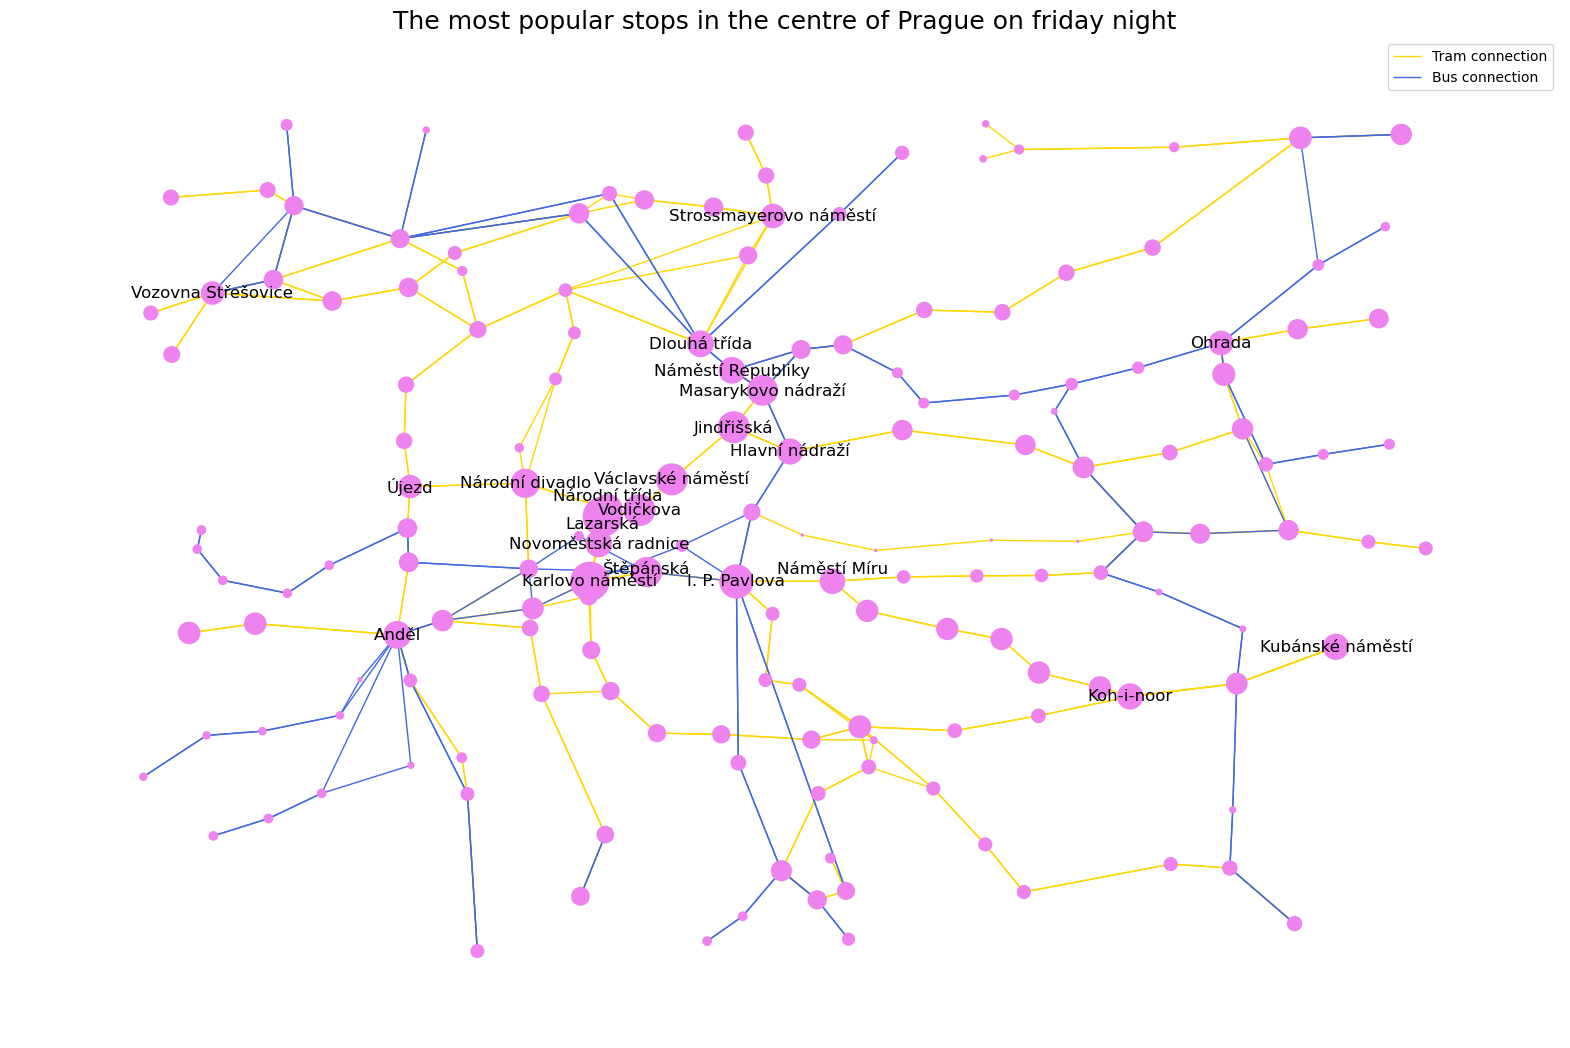

In [63]:
fig, ax = plt . subplots ( figsize = (20, 13) )
nx . draw_networkx_nodes ( fr_n_graph,
                           pos = stop_location,
                           nodelist = night_stops,
                           node_size = night_stops_weight,
                           node_color = "violet"
                         )
nx . draw_networkx_edges ( fr_n_graph, 
                           pos = stop_location, 
                           edgelist = tram_connections,
                           edge_color = "gold",
                           label = "Tram connection",
                           arrows = False,
                           node_size = night_stops_weight,
                         )
nx . draw_networkx_edges ( fr_n_graph, 
                           pos = stop_location, 
                           edgelist = bus_connections,
                           edge_color = "royalblue",
                           label = "Bus connection",
                           arrows = False,
                           node_size = night_stops_weight,
                         )
nx . draw_networkx_labels ( fr_n_graph,
                            pos = fr_n_location,
                            labels = { node[0]: node[0] for node in fr_n_graph . nodes ( data = True ) if ( node[1]["weight"] > 250 ) & ( node[0] in night_stops ) },
                            font_size = 12,
                            alpha = 1,
                          )
plt . title( "The most popular stops in the centre of Prague on friday night", size = 18 )
plt . legend ( )
plt . axis("off")

plt . show()

## That's all!!!